<div style="background-color:lightgray; color:black; padding:10px; border-radius:5px;">
  <h1>Sprint 8</h1>
</div>

## Tarea 8: Entrena los modelos de tu proyecto

## 🎯 **Objetivo:**
Entrenar los modelos al dataset analizado en el sprint 6

---

### **Ejercicio 1**. Entrenar el modelo

# Introducción

En estudios previos, se realizó un análisis exploratorio de datos (EDA) que permitió obtener una comprensión detallada de las características del conjunto de datos. Este análisis identificó variables categóricas y numéricas, reveló patrones clave y estableció las necesidades de preprocesamiento esenciales para optimizar su uso en modelos predictivos. A continuación, se resumen los principales hallazgos:

**Clasificación de las Variables:**
* Numéricas: Identificación de variables con asimetrías, curtosis y outliers (balance, duration, campaign, pdays, previous).
* Categóricas: Clasificación en nominales y ordinales (education, month, job, entre otras).

**Tratamiento de Variables Numéricas:**
* Outliers: Winsorización aplicada para mitigar el impacto de valores extremos.
* Transformación logarítmica: Usada en variables con distribuciones altamente sesgadas.
* Escalado: RobustScaler para variables con outliers y MinMaxScaler para las demás.

**Imputación de Valores Faltantes:**
* Numéricas: Imputación con la mediana.
* Categóricas: Imputación con "unknown" para mantener coherencia.

**Codificación de Variables Categóricas:**
* Ordinales: Codificación con valores específicos para reflejar orden lógico (education, month).
* Nominales: One-Hot Encoding aplicado con eliminación de la columna de referencia para reducir dimensionalidad.

# Objetivo de este Estudio
En este proyecto, se busca implementar un modelo de clasificación, específicamente una **Regresión Logística**, que permita predecir la probabilidad de que un cliente suscriba un depósito bancario. Para ello, se empleará una pipeline que automatice el preprocesamiento de los datos, asegurando la reproducibilidad de las transformaciones realizadas en los estudios previos.

# Enfoque Metodológico

* Pipeline de Transformaciones: Construir una pipeline que integre las imputaciones, transformaciones logarítmicas, winsorización, escalado y codificación de variables. Esto garantizará un flujo estructurado y replicable del preprocesamiento.

* Entrenamiento del Modelo:
    - Dividir los datos en conjuntos de entrenamiento y prueba mediante estratificación para mantener la distribución de la variable objetivo.
    - Entrenar el modelo de Regresión Logística utilizando los datos preprocesados.

* Evaluación y Métricas:
    - Evaluar el modelo mediante métricas clave como accuracy, f1-score, roc-auc, precisión y recall.
    - Generar una matriz de confusión para analizar los errores en la clasificación de las clases.

* Optimización: Ajustar los hiperparámetros del modelo para mejorar su desempeño.

* Interpretación y Comparación: Analizar los coeficientes del modelo para identificar las variables más influyentes y comparar los resultados obtenidos con los objetivos del negocio.

* Guardado para Productivización: Al finalizar, guardar la pipeline y el modelo entrenado para su uso en producción mediante herramientas como Streamlit.

## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score,  make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# 2. Carga el dataset

In [3]:
bank_data= pd.read_csv('/home/neivysg/project_machine_learning/sprint_8/bank_dataset.CSV')
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56.0,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41.0,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55.0,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54.0,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33.0,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39.0,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32.0,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43.0,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


# 3. Informació general del dataset

In [4]:
# Exploración inicial del DataFrame
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11152 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11157 non-null  object 
 3   education  11155 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


El método data.info() nos proporciona un resumen general del conjunto de datos:

- Total de entradas: 11,162 registros con 17 columnas.
Tipos de datos:
- Variables numéricas (de tipo float64 y int64): como age, balance, day, duration, campaign, pdays, previous.
- Variables categóricas (object): job, marital, education, default, housing, loan, contact, month, poutcome, y deposit.
- Valores faltantes:age, marital, y education tienen algunos valores faltantes, ya manejados previamente en el análisis.

Este resumen nos confirma que las variables están bien definidas para el análisis exploratorio y el modelado posterior, permitiendo un análisis demográfico, financiero y de interacción de los clientes en relación con la suscripción de depósitos.

## 4. Crear Pipeline de Pre-procesamiento

In [5]:
# Clasificación de variables
ordinal_features = ['education', 'month']
ordinal_orders = {
    'education': ['unknown', 'primary', 'secondary', 'tertiary'],
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
}

nominal_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']
low_freq_features = ['job', 'contact', 'poutcome']

# Variables numéricas
outlier_features = ['balance', 'duration', 'pdays']
non_outlier_features = ['age', 'campaign', 'previous']

In [6]:
# Función de Winsorización
# Función para aplicar winsorización
def winsorize_transform(X):
    return np.apply_along_axis(lambda col: winsorize(col, limits=[0.05, 0.05]), axis=0, arr=X)

# Función para transformación logarítmica
def log_transform(X):
    X = np.where(X <= 0, X + np.abs(X.min(axis=0)) + 1, X)  # Ajustar valores negativos o cero
    return np.log1p(X)

class LowFrequencyGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.low_freq_categories_ = None

    def fit(self, X, y=None):
        # Calcular categorías de baja frecuencia para cada columna
        self.low_freq_categories_ = []
        for col in range(X.shape[1]):
            unique, counts = np.unique(X[:, col], return_counts=True)
            freq = counts / len(X)
            low_freq_categories = unique[freq < self.threshold]
            self.low_freq_categories_.append(low_freq_categories)
        return self

    def transform(self, X):
        # Reemplazar categorías de baja frecuencia por 'Otros'
        X_transformed = X.copy()
        for col in range(X.shape[1]):
            low_freq_categories = self.low_freq_categories_[col]
            X_transformed[:, col] = np.where(
                np.isin(X_transformed[:, col], low_freq_categories), 'Otros', X_transformed[:, col]
            )
        return X_transformed

In [7]:
# Pipelines individuales
# 1. Para variables ordinales
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('ordinal_encoder', OrdinalEncoder(categories=[ordinal_orders[feature] for feature in ordinal_features]))
])

# 2. Para variables nominales con agrupamiento de baja frecuencia
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('low_freq_grouper', LowFrequencyGrouper(threshold=0.05)),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# 3. Para variables numéricas con outliers
outlier_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('winsorizer', FunctionTransformer(winsorize_transform, validate=False)),
    ('log_transformer', FunctionTransformer(log_transform, validate=False)),
    ('scaler', RobustScaler())
])

# 4. Para variables numéricas sin outliers
non_outlier_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

In [8]:
# Preprocesamiento combinado
preprocessor = ColumnTransformer(
    transformers=[
        ('outlier_num', outlier_pipeline, outlier_features),
        ('non_outlier_num', non_outlier_pipeline, non_outlier_features),
        ('ord', ordinal_pipeline, ordinal_features),
        ('nom', nominal_pipeline, low_freq_features + list(set(nominal_features) - set(low_freq_features)))
    ]
)

In [9]:
# Redefinir pipeline completa
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 5. Dividir los Datos en Entrenamiento y Prueba:

Dividir los datos permite evaluar el rendimiento del modelo en datos no vistos, lo cual es esencial para verificar su capacidad de generalización. Se asumió el 80% entrenamiento y 20% prueba.

In [10]:
# Separar características (X) y variable objetivo (y)
X = bank_data.drop(columns=['deposit'])  # Asumiendo que 'deposit' es la variable objetivo
y = bank_data['deposit']

# Dividir los datos con estratificación según la variable objetivo 'deposit'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Verificar la distribución de la variable objetivo en los conjuntos
print("# --- Verificación de Estratificación --- #")
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts(normalize=True))

# --- Verificación de Estratificación --- #
Distribución en el conjunto de entrenamiento:
deposit
no     0.526151
yes    0.473849
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
deposit
no     0.526198
yes    0.473802
Name: proportion, dtype: float64


In [12]:
# Codificar y_train y y_test en valores numéricos
y_train = y_train.replace({'yes': 1, 'no': 0})
y_test = y_test.replace({'yes': 1, 'no': 0})

# Confirmar la codificación
print("# --- Confirmación de Codificación de y_train y y_test --- #")
print("Primeras filas de y_train:")
print(y_train.head())

print("\nPrimeras filas de y_test:")
print(y_test.head())

# --- Confirmación de Codificación de y_train y y_test --- #
Primeras filas de y_train:
8644    0
2632    1
3056    1
1080    1
4006    1
Name: deposit, dtype: int64

Primeras filas de y_test:
8220    0
2521    1
7949    0
7879    0
616     1
Name: deposit, dtype: int64


/tmp/ipykernel_2284/2543419428.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'yes': 1, 'no': 0})
/tmp/ipykernel_2284/2543419428.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = y_test.replace({'yes': 1, 'no': 0})


**Observaciones**

Las variables y_train y y_test han sido codificadas:
* yes → 1 (Cliente aceptó el depósito).
* no → 0 (Cliente no aceptó el depósito).

# 6.  Ajustar la pipeline de preprocesamiento a los datos de entrenamiento y prueba

La pipeline creada puede procesar automáticamente las transformaciones en las características. Primero, se ajusta la pipeline con los datos de entrenamiento y luego se aplicas tanto al conjunto de entrenamiento como al de prueba.

In [13]:
# Ajustar y transformar
try:
    X_train_transformed = full_pipeline.fit_transform(X_train)
    X_test_transformed = full_pipeline.transform(X_test)
    print("Pipeline ajustado y datos transformados correctamente.")
except Exception as e:
    print("Error durante la transformación:", e)

# Verificar las dimensiones de los datos transformados
print("Dimensiones de los datos transformados:")
print("X_train_transformed:", X_train_transformed.shape)
print("X_test_transformed:", X_test_transformed.shape)

Pipeline ajustado y datos transformados correctamente.
Dimensiones de los datos transformados:
X_train_transformed: (8929, 25)
X_test_transformed: (2233, 25)


In [14]:
# Verificar columnas con NaN en X_train antes de la transformación
print("Columnas con NaN antes de la transformación:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

# Verificar columnas con NaN en X_train_transformed después de aplicar el pipeline
transformed_df = pd.DataFrame(X_train_transformed)
print("Columnas con NaN después de la transformación:")
print(transformed_df.isnull().sum()[transformed_df.isnull().sum() > 0])


Columnas con NaN antes de la transformación:
age          7
marital      4
education    6
dtype: int64
Columnas con NaN después de la transformación:
Series([], dtype: int64)


In [15]:
X_train_transformed = pd.DataFrame(X_train_transformed)
X_train_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.018358,-0.006209,0.000000,0.363636,0.032258,0.000000,2.0,6.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.583118,0.021352,1.299728,0.363636,0.000000,0.137931,3.0,8.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.523669,-0.176028,1.288925,0.090909,0.000000,0.017241,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.679683,0.877136,0.000000,0.324675,0.032258,0.000000,2.0,10.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
4,-0.354851,0.056656,0.000000,0.246753,0.016129,0.000000,0.0,8.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8929 entries, 0 to 8928
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8929 non-null   float64
 1   1       8929 non-null   float64
 2   2       8929 non-null   float64
 3   3       8929 non-null   float64
 4   4       8929 non-null   float64
 5   5       8929 non-null   float64
 6   6       8929 non-null   float64
 7   7       8929 non-null   float64
 8   8       8929 non-null   float64
 9   9       8929 non-null   float64
 10  10      8929 non-null   float64
 11  11      8929 non-null   float64
 12  12      8929 non-null   float64
 13  13      8929 non-null   float64
 14  14      8929 non-null   float64
 15  15      8929 non-null   float64
 16  16      8929 non-null   float64
 17  17      8929 non-null   float64
 18  18      8929 non-null   float64
 19  19      8929 non-null   float64
 20  20      8929 non-null   float64
 21  21      8929 non-null   float64
 22  

In [17]:
X_test_transformed = pd.DataFrame(X_test_transformed)
X_test_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.129232,0.464727,0.000000,0.181818,0.016129,0.000000,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.146045,0.499862,0.000000,0.233766,0.000000,0.000000,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.102183,-0.732111,1.525915,0.441558,0.016129,0.051724,2.0,9.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-2.143220,0.045063,0.000000,0.220779,0.032258,0.000000,2.0,4.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-2.143220,0.909845,0.000000,0.298701,0.032258,0.000000,2.0,6.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [18]:
X_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2233 non-null   float64
 1   1       2233 non-null   float64
 2   2       2233 non-null   float64
 3   3       2233 non-null   float64
 4   4       2233 non-null   float64
 5   5       2233 non-null   float64
 6   6       2233 non-null   float64
 7   7       2233 non-null   float64
 8   8       2233 non-null   float64
 9   9       2233 non-null   float64
 10  10      2233 non-null   float64
 11  11      2233 non-null   float64
 12  12      2233 non-null   float64
 13  13      2233 non-null   float64
 14  14      2233 non-null   float64
 15  15      2233 non-null   float64
 16  16      2233 non-null   float64
 17  17      2233 non-null   float64
 18  18      2233 non-null   float64
 19  19      2233 non-null   float64
 20  20      2233 non-null   float64
 21  21      2233 non-null   float64
 22  

# 7. Entrenar Modelo: Regresión Logística

## 7.1 Crosvalidation y entreno de modelo 

In [19]:
#Configurar el modelo y realizar validación cruzada

# Crear el modelo de Regresión Logística
model = LogisticRegression(max_iter=1000, random_state=42)

# Configurar K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Validación cruzada para Accuracy
cv_accuracy_scores = cross_val_score(model, X_train_transformed, y_train, cv=kf, scoring='accuracy')

# Validación cruzada para F1-Score
cv_f1_scores = cross_val_score(model, X_train_transformed, y_train, cv=kf, scoring='f1')

# Validación cruzada para ROC-AUC
cv_roc_auc_scores = cross_val_score(model, X_train_transformed, y_train, cv=kf, scoring='roc_auc')

In [20]:
# Mostrar los resultados de la validación cruzada
print(f"Cross-Validation Accuracy Scores: {cv_accuracy_scores}")
print(f"Promedio de Accuracy: {cv_accuracy_scores.mean():.4f}")
print(f"Desviación Estándar de Accuracy: {cv_accuracy_scores.std():.4f}\n")

print(f"Cross-Validation F1 Scores: {cv_f1_scores}")
print(f"Promedio de F1-Score: {cv_f1_scores.mean():.4f}\n")

print(f"Cross-Validation ROC-AUC Scores: {cv_roc_auc_scores}")
print(f"Promedio de ROC-AUC: {cv_roc_auc_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.81634938 0.80291153 0.79059351 0.80515118 0.80067189 0.79731243
 0.81522956 0.82978723 0.80515118 0.80941704]
Promedio de Accuracy: 0.8073
Desviación Estándar de Accuracy: 0.0105

Cross-Validation F1 Scores: [0.80193237 0.78588808 0.789177   0.79383886 0.78809524 0.8
 0.81056257 0.82648402 0.78085642 0.8       ]
Promedio de F1-Score: 0.7977

Cross-Validation ROC-AUC Scores: [0.89483196 0.88673241 0.87341061 0.88225926 0.87991297 0.87148806
 0.88279948 0.90764954 0.87496945 0.88860961]
Promedio de ROC-AUC: 0.8843


In [21]:
#Entrenar el modelo en el conjunto completo de entrenamiento
# Entrenar el modelo
model.fit(X_train_transformed, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test_transformed)
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]  # Obtener probabilidades para ROC-AUC

In [22]:
#Calcular las métricas de evaluación en el conjunto de prueba
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Imprimir métricas clave
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")

# Mostrar el reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

Exactitud (Accuracy): 0.7980
F1-Score: 0.7894
ROC-AUC: 0.8822

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1175
           1       0.78      0.80      0.79      1058

    accuracy                           0.80      2233
   macro avg       0.80      0.80      0.80      2233
weighted avg       0.80      0.80      0.80      2233

Matriz de Confusión:
[[937 238]
 [213 845]]


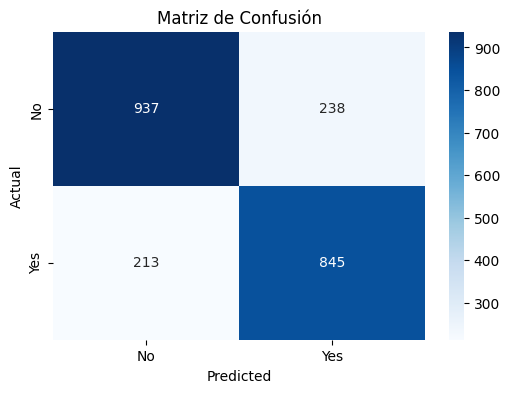

In [23]:
# Graficar la matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

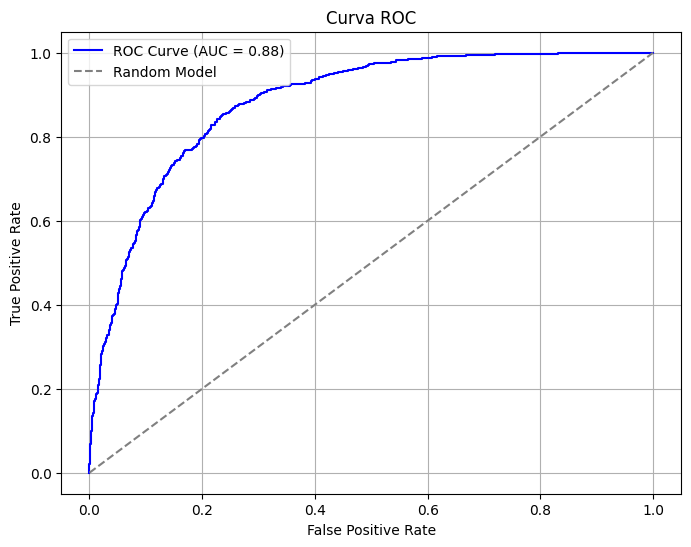

In [24]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Comparar métricas de validación cruzada y prueba final
print("# --- Comparación de Resultados --- #")
print(f"Promedio de Accuracy (Cross-Validation): {cv_accuracy_scores.mean():.4f}")
print(f"Accuracy en Conjunto de Prueba: {accuracy:.4f}\n")

print(f"Promedio de F1-Score (Cross-Validation): {cv_f1_scores.mean():.4f}")
print(f"F1-Score en Conjunto de Prueba: {f1:.4f}\n")

print(f"Promedio de ROC-AUC (Cross-Validation): {cv_roc_auc_scores.mean():.4f}")
print(f"ROC-AUC en Conjunto de Prueba: {roc_auc:.4f}")

# --- Comparación de Resultados --- #
Promedio de Accuracy (Cross-Validation): 0.8073
Accuracy en Conjunto de Prueba: 0.7980

Promedio de F1-Score (Cross-Validation): 0.7977
F1-Score en Conjunto de Prueba: 0.7894

Promedio de ROC-AUC (Cross-Validation): 0.8843
ROC-AUC en Conjunto de Prueba: 0.8822


**Resumen del análisis**
El proyecto busca crear un modelo de perfilado inteligente de clientes para maximizar la tasa de suscripción de depósitos a plazo fijo. Se evaluaron los resultados del modelo de Regresión Logística, considerando métricas clave como Accuracy, F1-Score y ROC-AUC, junto con una matriz de confusión y una curva ROC.

* **Resultados principales**
    - Accuracy (validación cruzada): 80.70% (Desviación estándar: 0.0107)
    - F1-Score (validación cruzada): 79.76%
    - ROC-AUC (validación cruzada): 88.43%

* **Conjunto de prueba:** 
    - Accuracy: 79.80%
    - F1-Score: 78.92%
    - ROC-AUC: 88.23%

* **Matriz de Confusión:**
    - Falsos positivos: 237 (impacto en costos de marketing).
    - Falsos negativos: 214 (oportunidades de negocio perdidas).

* **Relación con el negocio** 
    - El modelo cumple con el objetivo principal de distinguir clientes interesados en suscribir un depósito de aquellos que no lo están, con un buen desempeño en las métricas clave.
    - La métrica de ROC-AUC (0.88) muestra que el modelo tiene una buena capacidad para discriminar entre ambas clases, alineándose con los objetivos del negocio descritos en el documento​(Sprint_7.2_Proyecto ML).

* **Fortalezas:**
    - Un balance razonable entre precisión (accuracy) y capacidad predictiva (ROC-AUC).
    - La F1-Score (0.7892 en el conjunto de prueba) indica que el modelo logra minimizar los falsos negativos, lo cual es crucial para evitar la pérdida de clientes potenciales.

* **Debilidades:**
    - Los falsos positivos (237) y falsos negativos (214) representan áreas donde se podría mejorar, ya que estos errores implican costos innecesarios en marketing y oportunidades perdidas, respectivamente.
    - La desviación estándar de accuracy (0.0107) muestra una ligera variabilidad en el rendimiento del modelo durante la validación cruzada.

* **Próximos pasos**
El modelo actual de Regresión Logística es funcional y ofrece resultados sólidos, especialmente en términos de ROC-AUC (0.88). Sin embargo, se recomienda implementar técnicas de optimización para reducir los falsos negativos y positivos, mejorando la personalización de campañas y maximizando la tasa de suscripción de depósitos a plazo fijo. Esto ayudará a cumplir con los objetivos estratégicos del banco, mejorando tanto la eficacia del marketing como las tasas de conversión. 

    - **Optimización del modelo:** Ajustar hiperparámetros de la regresión logística para reducir los falsos negativos.

## 7.2. Optimización de modelo

En el caso de Regresión Logística, los principales hiperparámetros a ajustar son:
* C (Regularización): Controla la fuerza de la regularización. Valores más bajos implican mayor regularización.
* penalty (Penalización): Define el tipo de regularización a aplicar. Las opciones comunes son:
    - 'l1' para regularización Lasso.
    - 'l2' para regularización Ridge.
* solver (Algoritmo de optimización): Controla cómo se ajusta el modelo. Depende de la penalización elegida:
    - 'liblinear': Compatible con 'l1' y 'l2'.
    - 'saga': Compatible con 'l1', 'l2' y elastic net (si se requiere).
    - 'lbfgs': Usado generalmente para 'l2'.

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Definir los parámetros para buscar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularización
    'penalty': ['l1', 'l2'],       # Penalización
    'solver': ['liblinear', 'saga'],  # Solvers compatibles
}

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 particiones
    scoring='f1',  # Métrica objetivo
    verbose=1,  # Muestra el progreso
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Entrenar la búsqueda de hiperparámetros
grid_search.fit(X_train_transformed, y_train)

# Resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores parámetros:", best_params)
print("Mejor F1-Score durante la validación cruzada:", best_score)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/neivysg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/neivysg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/neivysg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/neivysg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/neivysg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/neivysg/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag

Mejores parámetros: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Mejor F1-Score durante la validación cruzada: 0.7975243635442805


In [27]:
# Entrenar el modelo final con los mejores parámetros
best_model = LogisticRegression(**best_params, random_state=42, max_iter=1000)
best_model.fit(X_train_transformed, y_train)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [28]:
# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test_transformed)
y_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]

In [29]:
# Métricas de evaluación
accuracy = best_model.score(X_test_transformed, y_test)
f1 = classification_report(y_test, y_pred, target_names=['No', 'Yes'])
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [30]:
print("Exactitud (Accuracy):", accuracy)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

Exactitud (Accuracy): 0.8011643528884909
F1-Score:               precision    recall  f1-score   support

          No       0.82      0.80      0.81      1175
         Yes       0.78      0.80      0.79      1058

    accuracy                           0.80      2233
   macro avg       0.80      0.80      0.80      2233
weighted avg       0.80      0.80      0.80      2233

ROC-AUC: 0.8823231307565457


In [31]:
# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_matrix)

Matriz de Confusión:
 [[942 233]
 [211 847]]


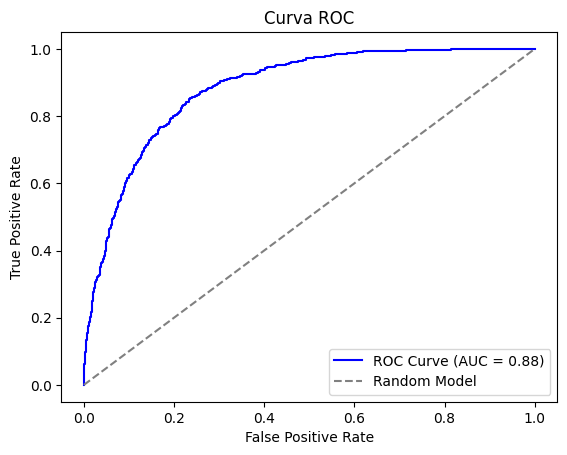

In [32]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Model')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Resultados Posteriores a la Optimización**

**Métricas en el conjunto de prueba:**
* Exactitud (Accuracy): 0.8012 (ligera mejora respecto a 0.7980 antes de la optimización).
* F1-Score:
* Clase No: 0.81
* Clase Yes: 0.79 (sin cambios significativos respecto al modelo sin optimización, que tenía 0.7892).
* ROC-AUC: 0.8823 (prácticamente idéntico al valor previo de 0.8823).
* Matriz de Confusión:
    - Verdaderos Positivos (TP): 847 (mejor que los 844 previos).
    - Verdaderos Negativos (TN): 942 (ligera mejora respecto a 938).
    - Falsos Positivos (FP): 233 (reducido respecto a 237).
    - Falsos Negativos (FN): 211 (ligera mejora respecto a 214).

**Comparación con el Modelo Sin Optimización**

**Promedio de Métricas:**
* Accuracy: Mejoró marginalmente de 0.7980 a 0.8012.
* F1-Score: Sin cambios significativos (se mantiene alrededor de 0.79).
* ROC-AUC: Sin mejora (sigue en 0.8823).

* Errores:
- FN (Falsos Negativos): Se redujeron ligeramente de 214 a 211, pero sigue siendo un área a trabajar porque representan oportunidades perdidas.
- FP (Falsos Positivos): También se redujeron de 237 a 233, indicando una mejor asignación de recursos.

* Cambios Globales:
Los cambios son marginales, lo que indica que el modelo base estaba ya bien ajustado para los datos proporcionados.

**Conclusión Final**

**Resultados de la Optimización:**
Aunque la optimización con GridSearchCV permitió encontrar mejores hiperparámetros, los resultados no mejoraron significativamente en comparación con el modelo base.
Esto puede deberse a que la Regresión Logística ya alcanzó su límite de desempeño dado el conjunto de datos y las características disponibles.

**Recomendación:**
* Explora modelos más avanzados, como:Random Forests: Para capturar relaciones no lineales entre las características y/o Gradient Boosting (XGBoost o LightGBM): Para manejar mejor las clases desbalanceadas.
* Ingeniería de características: Analizar si las variables actuales capturan toda la información relevante. 

# 8. Guardar modelo y pipeline

In [33]:
import pickle

# Guardar el modelo optimizado
model_path = "best_logistic_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

# Guardar la pipeline de transformación
pipeline_path = "data_transformation_pipeline.pkl"
with open(pipeline_path, "wb") as f:
    pickle.dump(full_pipeline, f)

print(f"Modelo guardado en: {model_path}")
print(f"Pipeline guardada en: {pipeline_path}")

Modelo guardado en: best_logistic_model.pkl
Pipeline guardada en: data_transformation_pipeline.pkl
